In [1]:
from tqdm import tqdm
from IPython.utils import io
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Activation

In [2]:
wb = pd.read_excel('LSVT_voice_rehabilitation.xlsx', 'Data')
features = pd.DataFrame(wb)
wb = pd.read_excel('LSVT_voice_rehabilitation.xlsx', 'Binary response')
class_label = pd.DataFrame(wb)
class1 = [float(i==1) for i in class_label.iloc[:,0]]
class2 = [float(i==2) for i in class_label.iloc[:,0]]
class_label = class_label.to_numpy().flatten()

In [3]:
for col in features.columns:
    features[col] = (features[col] - features[col].mean())/features[col].abs().max()
    
features

,Jitter->F0_abs_dif,Jitter->F0_dif_percent,Jitter->F0_PQ5_classical_Schoentgen,Jitter->F0_PQ5_classical_Baken,Jitter->F0_PQ5_generalised_Schoentgen,Jitter->F0_abs0th_perturb,Jitter->F0_CV,Jitter->F0_TKEO_mean,Jitter->F0_TKEO_std,Jitter->F0_TKEO_prc5,...,det_TKEO_std4_1_coef,det_TKEO_std4_2_coef,det_TKEO_std4_3_coef,det_TKEO_std4_4_coef,det_TKEO_std4_5_coef,det_TKEO_std4_6_coef,det_TKEO_std4_7_coef,det_TKEO_std4_8_coef,det_TKEO_std4_9_coef,det_TKEO_std4_10_coef
0,-0.066468,-0.082890,-0.082838,-0.033340,-0.061249,-0.020482,-0.020964,-0.038804,-0.034952,0.051697,...,0.007903,0.007720,0.007247,0.008839,0.008847,0.008944,0.007002,0.007106,0.007410,0.008703
1,-0.030866,-0.066103,-0.064835,0.067838,-0.081925,-0.019871,-0.020953,0.012543,0.063958,0.025804,...,0.098795,0.099252,0.098005,0.098818,0.099766,0.098824,0.098327,0.098659,0.099034,0.099850
2,0.158872,0.561317,0.566592,-0.000542,0.519678,0.026310,0.066991,-0.032220,-0.108107,-0.009437,...,-0.200743,-0.199414,-0.200822,-0.203238,-0.203230,-0.207259,-0.209097,-0.208821,-0.208217,-0.209700
3,-0.094019,-0.098523,-0.098027,0.005216,-0.080907,-0.028275,-0.021021,-0.075258,-0.112129,0.061130,...,-0.144775,-0.144617,-0.145622,-0.145107,-0.145004,-0.145269,-0.146545,-0.146343,-0.146087,-0.144950
4,-0.072234,-0.085704,-0.099164,0.308458,0.003853,-0.025916,-0.014811,-0.028485,-0.015284,0.057475,...,-0.013641,-0.011525,-0.016298,-0.013042,-0.013413,-0.013737,-0.015313,-0.015339,-0.014901,-0.014022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,-0.052890,-0.051978,-0.050158,0.038097,-0.069764,-0.023081,-0.020920,-0.053079,-0.073146,0.046347,...,-0.051373,-0.050153,-0.049881,-0.048588,-0.048659,-0.049199,-0.048967,-0.049027,-0.048948,-0.048341
122,0.229291,0.230740,0.235550,0.099006,0.043501,-0.010882,-0.019039,0.024780,-0.017329,-0.092600,...,0.013112,0.015052,0.019401,0.020243,0.019213,0.018342,0.018686,0.017352,0.018778,0.018789
123,-0.073946,-0.073197,-0.072134,-0.050451,-0.060094,0.000215,-0.020981,-0.066567,-0.095212,0.056477,...,-0.089750,-0.089863,-0.091204,-0.091731,-0.091193,-0.091616,-0.092902,-0.092842,-0.092632,-0.090879
124,-0.055234,-0.069454,-0.067720,-0.009375,-0.075070,-0.022874,-0.020989,-0.037867,-0.034837,0.048065,...,0.011250,0.011519,0.010806,0.011183,0.011701,0.011451,0.011090,0.010679,0.010554,0.011329


In [4]:
classes = {'Acceptable': class1, 'Unacceptable': class2}
classes = pd.DataFrame(classes)
classes

,Acceptable,Unacceptable
0,1.0,0.0
1,0.0,1.0
2,0.0,1.0
3,1.0,0.0
4,0.0,1.0
...,...,...
121,0.0,1.0
122,0.0,1.0
123,1.0,0.0
124,0.0,1.0


In [5]:
model = Sequential([
    
    InputLayer(input_shape=(features.shape[1])),
    
    Dense(7, activation='sigmoid'),
    
    Dense(5, activation='sigmoid'),
    
    Dense(2, activation='relu')
])

model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
             )

model.summary()

model.save_weights('model_weights/initial_weights_voice')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 2177      
                                                                 
 dense_1 (Dense)             (None, 5)                 40        
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 2,229
Trainable params: 2,229
Non-trainable params: 0
_________________________________________________________________


In [6]:
acc = 0
j = 0
for train_index, test_index in KFold(10).split(features):
    x_train, x_test = features.iloc[train_index,:], features.iloc[test_index,:]
    y_train, y_test = classes.iloc[train_index,:], classes.iloc[test_index,:]
    model.load_weights('model_weights/initial_weights_voice')
    with io.capture_output() as captured:
        model.fit(x_train, y_train, epochs=1000)
    acc += model.evaluate(x_test, y_test)[1]
    j+=1

1/1 [==============================] - 0s 26ms/step - loss: 1.6591 - accuracy: 0.7500


In [7]:
acc/j

0.8012820541858673

In [8]:
model.fit(features, classes, epochs=500)

Epoch 1/500
4/4 [==============================] - 0s 5ms/step - loss: 0.1584 - accuracy: 0.9762
Epoch 2/500
4/4 [==============================] - 0s 5ms/step - loss: 0.1504 - accuracy: 0.9762
Epoch 3/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1446 - accuracy: 0.9762
Epoch 4/500
4/4 [==============================] - 0s 4ms/step - loss: 0.0519 - accuracy: 0.9841
Epoch 5/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0447 - accuracy: 0.9762
Epoch 6/500
4/4 [==============================] - 0s 4ms/step - loss: 0.0293 - accuracy: 0.9841
Epoch 7/500
4/4 [==============================] - 0s 4ms/step - loss: 0.0276 - accuracy: 0.9921
Epoch 8/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0254 - accuracy: 0.9921
Epoch 9/500
4/4 [==============================] - 0s 4ms/step - loss: 0.0233 - accuracy: 0.9921
Epoch 10/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0215 - accuracy: 0.9921
Epoch 11/500
4/4 [===========

In [9]:
grad_sum = 0
for col_name in tqdm(features.columns):
    pointFrame = features.loc[:, features.columns != col_name]
    for i in features[col_name]:
        pointFrame[col_name] = i*np.ones(len(features.index))
        points = tf.Variable(pointFrame, dtype='float')
        with tf.GradientTape() as tape:
            pred = model(points, training=False)
        grads = tape.gradient(pred, points)
        grad_sum += np.abs(grads.numpy())
saliency_order = np.argsort(np.sum(np.abs(grad_sum),0))

100%|██████████| 310/310 [03:20<00:00,  1.54it/s]


[]

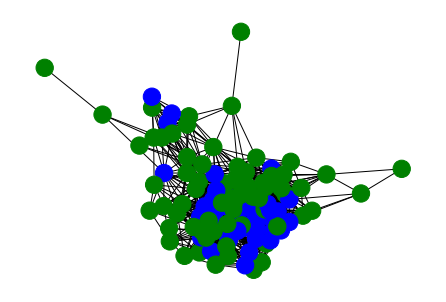

In [10]:
num_features = 35

salient_features = features.iloc[:,saliency_order[0:num_features]]
A = np.zeros((features.shape[0], features.shape[0]))
for i in features.index:
    for j in range(i):
        A[i,j] = np.linalg.norm(salient_features.iloc[i,:] - salient_features.iloc[j,:])
A = A + np.transpose(A)
# print(A)
# p = np.median(A).astype('int')
p = 0.5
A = (A <= p)
A = A - np.eye(A.shape[0])
rows, cols = np.where(A==1)
edges = zip(rows.tolist(), cols.tolist())
G = nx.Graph()
G.add_edges_from(edges, node_size=1)
color_map = np.array([])
acceptable = np.array([])
unacceptable = np.array([])
for node in G:
    if (class_label[node]==1):
        acceptable = np.append(acceptable, node)
        color_map = np.append(color_map, 'blue')
    else:
        unacceptable = np.append(unacceptable, node)
        color_map = np.append(color_map, 'green')
nx.draw(G, node_color=color_map)
plt.plot()

In [11]:
nx.is_connected(G) # tells whether or not the graph is connected
# nx.clustering(G) # gives the clustering value of each vertex

True

In [12]:
nx.number_connected_components(G) # number of different connected components

1

In [13]:
nx.density(G) # this tells how close the graph is to being fully connected

0.27239366138448706

In [14]:
nx.average_clustering(G) # clustering value for the whole graph

0.6790635968250107

In [15]:
nx.transitivity(G) # 3* number of triangles in G/ number of connected triads in G

0.646182526619865

[]

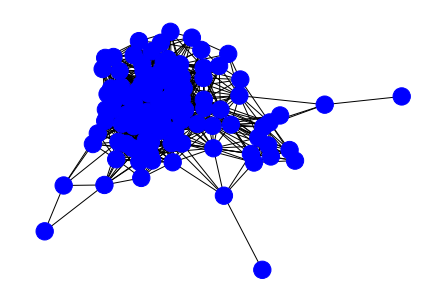

In [16]:
giant_component = G.subgraph(max(nx.connected_components(G), key=len))
color_map_GC = np.array([])
for node in G:
    if node in giant_component:
        color_map_GC = np.append(color_map_GC, 'blue')
    else:
        color_map_GC = np.append(color_map_GC, 'red')
nx.draw(G, node_color=color_map_GC)
plt.plot()

In [17]:
print(f'Eccentricity of giant component: {nx.eccentricity(giant_component)}') # largest possible shortest path distance between a vertex and all other vertices
print(f'Diameter of giant component: {nx.diameter(giant_component)}') # maximum shortest distance between a pair of vertices in G, it is the largest possible eccentricity value of a vertex
print(f'Radius of giant component: {nx.radius(giant_component)}') #  minimum eccentricity value of a vertex

print(f'Degree centrality: \n{nx.degree_centrality(G)}') # number of edges incident upon a vertex
print(f'Maximum degree centrality: {max(nx.degree_centrality(G))}')
print(f'Degree histogram: {nx.degree_histogram(G)}')

# below gives us the different centrality measures for the vertices of the graphs
print(f'Eigenvector centrality: \n{nx.eigenvector_centrality(G)}')
print(f'Maximum eigenvector centrality: {max(nx.eigenvector_centrality(G))}')
print(f'Closeness centrality: \n{nx.closeness_centrality(G)}')
print(f'Maximum closeness centrality: {max(nx.closeness_centrality(G))}')
print(f'Betweeness centrality: \n{nx.betweenness_centrality(G)}')
print(f'Maximum betweeness centrality: {max(nx.betweenness_centrality(G))}')

Eccentricity of giant component: {0: 4, 1: 5, 4: 5, 5: 4, 9: 4, 12: 4, 15: 5, 16: 5, 18: 4, 20: 5, 24: 4, 28: 4, 29: 5, 33: 4, 34: 4, 35: 4, 36: 4, 39: 4, 45: 4, 46: 4, 48: 4, 57: 4, 69: 4, 72: 5, 73: 5, 74: 4, 78: 4, 81: 4, 84: 4, 88: 4, 93: 5, 94: 4, 96: 4, 100: 4, 101: 4, 103: 4, 105: 4, 106: 4, 108: 4, 112: 4, 113: 5, 114: 5, 118: 4, 119: 4, 121: 4, 122: 4, 124: 4, 125: 4, 54: 5, 82: 4, 83: 5, 3: 5, 6: 5, 27: 5, 30: 5, 56: 5, 70: 6, 71: 6, 76: 5, 87: 5, 90: 5, 91: 5, 99: 5, 102: 5, 115: 5, 116: 5, 117: 5, 120: 5, 123: 5, 85: 4, 8: 5, 17: 4, 19: 4, 21: 5, 23: 5, 31: 5, 32: 4, 38: 4, 40: 4, 60: 4, 89: 5, 95: 5, 97: 4, 109: 5, 110: 4, 92: 5, 41: 5, 52: 6, 22: 4, 10: 5, 11: 4, 13: 4, 50: 4, 51: 4, 58: 5, 63: 4, 65: 4, 66: 5, 80: 5, 37: 4, 47: 4, 49: 5, 61: 4, 25: 5, 64: 5, 111: 5, 43: 7, 53: 6, 77: 7, 79: 6}
Diameter of giant component: 7
Radius of giant component: 4
Degree centrality: 
{0: 0.43119266055045874, 1: 0.1834862385321101, 4: 0.1743119266055046, 5: 0.4954128440366973, 9: 0.4

In [18]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(salient_features)
print('Number of Iterations: ', kmeans.n_iter_)
predicted_label = kmeans.labels_

Number of Iterations:  2


In [19]:
print('Cluster Centers: ', kmeans.cluster_centers_)

Cluster Centers:  [[ 8.74184828e-03  1.41467896e-01 -2.93371516e-02  1.45324622e-01
   1.89361421e-02 -6.21851415e-03  2.19700562e-02  1.48358480e-01
   2.43116368e-02 -6.19148326e-03  1.00460445e-02  5.35871279e-03
   1.87671594e-02  1.45312120e-01 -4.68563022e-02  1.41048410e-02
   1.45760469e-01  2.03912165e-02 -1.10818010e-02  1.46543258e-01
   2.14475301e-02  1.80772253e-02  1.45278094e-01 -2.32408287e-03
   1.45249149e-01 -5.36386868e-05  1.44796630e-01  1.28438629e-02
  -2.76072347e-02  1.47543336e-01 -2.43408883e-01  4.52061334e-02
   1.41752537e-01  1.42881323e-01 -2.43147999e-01]
 [-2.73182759e-03 -4.42087176e-02  9.16785987e-03 -4.54139444e-02
  -5.91754441e-03  1.94328567e-03 -6.86564256e-03 -4.63620252e-02
  -7.59738652e-03  1.93483852e-03 -3.13938892e-03 -1.67459775e-03
  -5.86473730e-03 -4.54100374e-02  1.46425944e-02 -4.40776280e-03
  -4.55501465e-02 -6.37225515e-03  3.46306282e-03 -4.57947681e-02
  -6.70235316e-03 -5.64913290e-03 -4.53994044e-02  7.26275896e-04
  -4.53

In [20]:
print('Inertia: ', kmeans.inertia_) # SSE

Inertia:  55.68269295662746


In [23]:
compared_classes = class_label - 1
print('KMeans accuracy: ', np.count_nonzero(compared_classes!=predicted_label)/len(predicted_label))

KMeans accuracy:  0.5079365079365079


[]

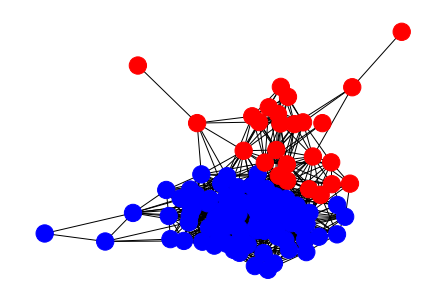

In [22]:
color_map_cluster = np.array([])
for node in G:
    if (predicted_label[node]==0):
        color_map_cluster = np.append(color_map_cluster, 'red')
    else:
        color_map_cluster = np.append(color_map_cluster, 'blue')
nx.draw(G, node_color=color_map_cluster)
plt.plot()